# Convolutional Autoencoder

## 1. initialize

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import pickle
import os
import matplotlib.pyplot as plt
import PIL

%matplotlib inline

In [2]:
from IPython.display import SVG
from tensorflow.keras.utils import model_to_dot

In [3]:
np.random.seed(1) # to make the results reproducible

In [4]:
# TensorFlow 2.1, Keras - workaround:
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
config.gpu_options.per_process_gpu_memory_fraction = 0.9
tf.compat.v1.keras.backend.set_session(tf.compat.v1.Session(config=config))

In [5]:
# Detect the number of train data mini batches. Shuffle them and divide into a train/test parts.

fname_pattern = "./bengaliai-cv19/train_batch_{:03d}.pickle"
train_test_split = 0.7

mbatch_no = 0
while os.path.exists(fname_pattern.format(mbatch_no)):
    mbatch_no = mbatch_no + 1
print("{} train data file(s) found.".format(mbatch_no))

mbatch_train_no = round(mbatch_no * 0.7)
mbatch_test_no = mbatch_no - mbatch_train_no
mbatch_idx = np.random.permutation(mbatch_no)
mbatch_train_idx = mbatch_idx[:mbatch_train_no]
mbatch_test_idx = mbatch_idx[mbatch_train_no:]

197 train data file(s) found.


## 2. Helper functions

In [6]:
def load_batch(mbatch_no):
    fname = fname_pattern.format(mbatch_no)
    with open(fname, "rb") as f:
        batch = pickle.load(f)
        return batch

In [7]:
def prepare_image(img):
    sc_img = img.astype(float) / 255.
    pil_img = PIL.Image.fromarray(sc_img)
    new_pil_img = pil_img.resize((256, 256), PIL.Image.ANTIALIAS)
    return np.array(new_pil_img)

In [8]:
def prepare_batch(batch):
    new_X = np.zeros((batch['X'].shape[0], 256, 256), dtype=float)
    for i in range(new_X.shape[0]):
        new_X[i, :, :] = prepare_image(batch['X'][i, :, :])
    batch['X'] = new_X

In [9]:
def show_model(model):
    return SVG(model_to_dot(model, show_shapes=True, dpi=64).create(prog='dot', format='svg'))

## 3. check

In [10]:
print(tf.test.is_gpu_available())
print(tf.__version__)
print(tf.keras.__version__)

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
True
2.1.0
2.2.4-tf


In [11]:
batch = load_batch(0)
prepare_batch(batch)

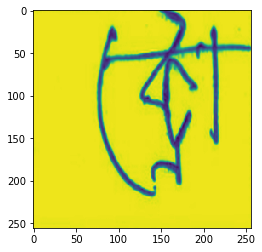

In [12]:
plt.imshow(batch['X'][0])

## 4. model

In [13]:
X = tf.keras.layers.Input(shape=[256, 256, 1], dtype=tf.float32)

Z1 = tf.keras.layers.Conv2D(filters=8, kernel_size=[5,5], strides=[1,1], padding="same", dilation_rate=[1,1])(X)
A1 = tf.keras.layers.LeakyReLU(alpha=0.1)(Z1)
P1 = tf.keras.layers.MaxPool2D(pool_size=[2,2], strides=[2,2], padding="same")(A1)

Z2 = tf.keras.layers.Conv2D(filters=16, kernel_size=[5,5], strides=[1,1], padding="same", dilation_rate=[1,1])(P1)
A2 = tf.keras.layers.LeakyReLU(alpha=0.1)(Z2)
P2 = tf.keras.layers.MaxPool2D(pool_size=[2,2], strides=[2,2], padding="same")(A2)

Z3 = tf.keras.layers.Conv2DTranspose(filters=8, kernel_size=[5,5], padding="same")(P2)
A3 = tf.keras.layers.LeakyReLU(alpha=0.1)(Z3)
U3 = tf.keras.layers.UpSampling2D(size=(2, 2))(A3)

Z4 = tf.keras.layers.Conv2DTranspose(filters=1, kernel_size=[5,5], padding="same")(U3)
A4 = tf.keras.layers.LeakyReLU(alpha=0.1)(Z4)
U4 = tf.keras.layers.UpSampling2D(size=(2, 2))(A4)

model = tf.keras.models.Model(inputs=X, outputs=U4) # Keras 2.2.4 from TensorFlow 2.1.0
model.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.MeanSquaredError(), metrics=['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 256, 256, 8)       208       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 256, 256, 8)       0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 8)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 16)      3216      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 128, 128, 16)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 16)        0     

In [14]:
def fit(img_batch, idx_from, idx_to, epochs):
    mini_img_batch = img_batch[idx_from:idx_to, :, :]
    mini_batch = mini_img_batch.reshape(mini_img_batch.shape[0], mini_img_batch.shape[1], mini_img_batch.shape[2], 1)
    input_X = tf.convert_to_tensor(mini_batch, dtype=tf.float32)
    model.fit(input_X, input_X, epochs=epochs)

In [15]:
def predict(img):
    inp_img = img.reshape(1, img.shape[0], img.shape[1], 1)
    pred_img = model.predict(inp_img)
    ret_img = pred_img.reshape(img.shape[0], img.shape[1])
    return ret_img

## 5. Train

In [16]:
fit(batch['X'], 0, 1024, epochs=100)

Train on 1024 samples
Epoch 1/100
1024/1024 [==============================] - 4s 4ms/sample - loss: 0.1015 - accuracy: 0.2421
Epoch 2/100
1024/1024 [==============================] - 1s 838us/sample - loss: 0.0285 - accuracy: 0.2668
Epoch 3/100
1024/1024 [==============================] - 1s 840us/sample - loss: 0.0135 - accuracy: 0.2696
Epoch 4/100
1024/1024 [==============================] - 1s 839us/sample - loss: 0.0065 - accuracy: 0.2710
Epoch 5/100
1024/1024 [==============================] - 1s 838us/sample - loss: 0.0043 - accuracy: 0.2711
Epoch 6/100
1024/1024 [==============================] - 1s 839us/sample - loss: 0.0034 - accuracy: 0.2711
Epoch 7/100
1024/1024 [==============================] - 1s 843us/sample - loss: 0.0030 - accuracy: 0.2711
Epoch 8/100
1024/1024 [==============================] - 1s 839us/sample - loss: 0.0027 - accuracy: 0.2711
Epoch 9/100
1024/1024 [==============================] - 1s 836us/sample - loss: 0.0025 - accuracy: 0.2711
Epoch 10/100
1024

1024/1024 [==============================] - 1s 838us/sample - loss: 0.0012 - accuracy: 0.2711
Epoch 77/100
1024/1024 [==============================] - 1s 828us/sample - loss: 0.0012 - accuracy: 0.2711
Epoch 78/100
1024/1024 [==============================] - 1s 838us/sample - loss: 0.0013 - accuracy: 0.2711
Epoch 79/100
1024/1024 [==============================] - 1s 839us/sample - loss: 0.0012 - accuracy: 0.2711
Epoch 80/100
1024/1024 [==============================] - 1s 826us/sample - loss: 0.0012 - accuracy: 0.2711
Epoch 81/100
1024/1024 [==============================] - 1s 830us/sample - loss: 0.0012 - accuracy: 0.2711
Epoch 82/100
1024/1024 [==============================] - 1s 827us/sample - loss: 0.0012 - accuracy: 0.2711
Epoch 83/100
1024/1024 [==============================] - 1s 831us/sample - loss: 0.0012 - accuracy: 0.2711
Epoch 84/100
1024/1024 [==============================] - 1s 824us/sample - loss: 0.0012 - accuracy: 0.2711
Epoch 85/100
1024/1024 [=================

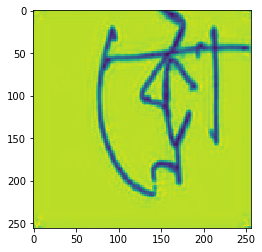

In [17]:
plt.imshow(predict(batch['X'][0]))

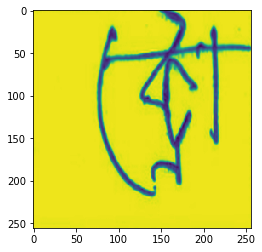

In [18]:
plt.imshow(batch['X'][0])